### Implementazione di un modello basato su un'architettura **encoder/decoder** in grado di segmentare l'immagine riconoscendo un animale domestico raffigurato all'interno.
    
La **Segmentazione di Immagini** è il processo, in computer-vision, di divisione di un'immagine in diverse zone (segmenti, gruppi di pixel) con lo scopo di modificare la rappresentazione di un'immagine in qualcosa di più significativo o facilmente analizzabile.    

-----

In questa esercitazione implementeremo un processo di image-segmentation sfruttando un modello di rete 
neurale artificiale che sfrutta tecniche di deep-learning e un'architettura convolutiva.     
    
*(**nb**: Nelle celle troverete alcune parti da completare, identificate da ***, in modo da rendere il notebook funzionante.
Il notebook è riportato già eseguito per facilitare il completamento del codice sorgente. Diversi commenti sparsi nelle celle
spiegano il funzionamento del modello proposto e le tecniche utilizzate.)*
    
-----
    
L'architettura utilizzata unisce alla struttura encoder/decoder le **skip-connection** tipiche dell'architettura convolutiva **U-Net**, in modo da sfruttare il riconoscimento di caratteristiche sempre più dettagliate / rilevanti che avviene di layer in layer nella parte di encoder, per ricostruire al meglio la mappa di segmentazione in output alla parte di decoder.    
Per velocizzare il processo di addestramento, si è sfruttata la tecnica del **transfer-learning**, utilizzando un modello pre-addestrato come encoder, in particolare la rete **MobileNetV2**; i layer finali usati in questo modello per classificare non vengono considerati e l'output relativo alle feature estratte è posto in input alla parte di decoder, che ha una struttura analoga all'encoder ma ribaltata, struttura costruita così per facilitare la ricostruzione da singole feature estratte di una mappa di segmentazione.
    
Al fine di permettere una generalizzazione migliore del modello (nella parte finale di questo script verrà testato il modello su immagini diverse da quelle presenti nel dataset di addestramento e nel dataset usato per la validazione), sono state applicate delle tecniche di **data-augmentation** che permettono di modificare ogni singolo esempio di input con delle trasformazioni completamente casuali sulle relative immagini, fornendo al modello potenzialmente infiniti esempi su cui addestrarsi (o meglio, potenzialmente infinte variazioni del dataset di addestramento).    

In [1]:
# importazione librerie necessarie

import matplotlib.pyplot as plt
import cv2  # pip install opencv-python
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

In [2]:
# recupero del dataset "Oxford-IIIT Pets Dataset"
# mette a disposizione delle tri-map, utili per
# l'addestramento di un modello in grado di
# segmentare le immagini di input.
#
# il dataset è formato da immagini di 37 razze
# di animali domestici, con 200 immagini per
# razza. Con ogni esempio è fornita la
# corrispondente etichetta e la maschera.
#
# Ad ogni pixel delle immagini viene assegnata
# una delle tre categorie:
#  1: animale
#  2: confine
#  3: sfondo

dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteZEE7PY/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteZEE7PY/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [3]:
# visualizzazione informazioni
# sul dataset

print(info)

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path=PosixGPath('/tmp/tmphnp_m68ttfds'),
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        

Definisco le funzioni che verranno utilizzate per la normalizzazione e per il caricamento dei dati nel modello (resize e normalizzazione)

In [4]:
# recupero del dataset
# e applicazione di resize + normalizzazione

def normalizza(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255
    input_mask -= 1
    return input_image, input_mask

def carica_esempio(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))
    input_image, input_mask = normalizza(input_image, input_mask)
    return input_image, input_mask

# Vado a specificare le operazioni che saranno da fare sui dataset
# di train e di test tramite la funzione map passando carica_esempio

ds_train = dataset['train'].map(carica_esempio , num_parallel_calls=tf.data.AUTOTUNE)
ds_test = dataset['test'].map(carica_esempio, num_parallel_calls=tf.data.AUTOTUNE)

Definisco una funzione di DataAugmentation che verrà utilizzata nel map del dataset

In [5]:
# definizione di una classe per applicare tecniche di
# data-augmentation sul dataset in modo automatico
# durante l'addestramento

class DataAugmentation(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # facendo usare lo stesso seed ad entrambe, verranno
    # applicate le stesse trasformazioni ad immagine e maschera
    self.augment_inputs_flip = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels_flip = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

    self.augment_inputs_rotation = tf.keras.layers.RandomRotation(factor=(-0.05, 0.05), seed=seed)
    self.augment_labels_rotation = tf.keras.layers.RandomRotation(factor=(-0.05, 0.05), seed=seed)
    
  def call(self, inputs, labels):
    inputs = self.augment_inputs_flip(inputs)
    labels = self.augment_labels_flip(labels)

    inputs = self.augment_inputs_rotation(inputs)
    labels = self.augment_labels_rotation(labels)
    
    return inputs, labels

Creo il dataset batchato

In [9]:
# costruzione della pipeline di input
# per l'addestramento

BATCH_SIZE = 4
BUFFER_SIZE = 1024

ds_train_batched = (
    ds_train
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .cache()
    .repeat()
    .map(DataAugmentation())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

ds_test_batched = ds_test.batch(BATCH_SIZE)

-


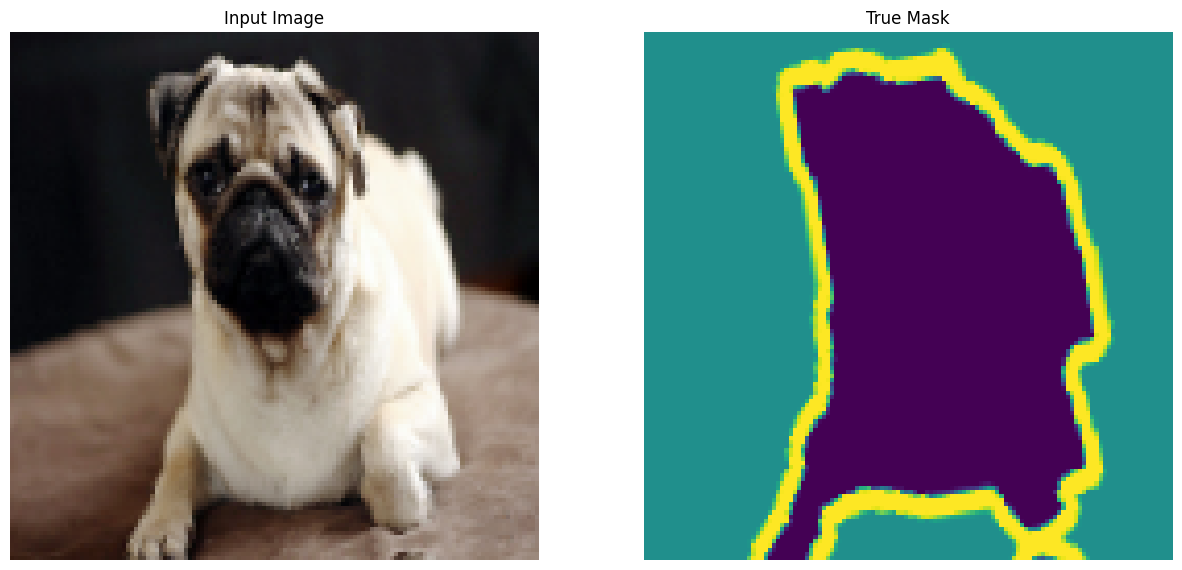

-


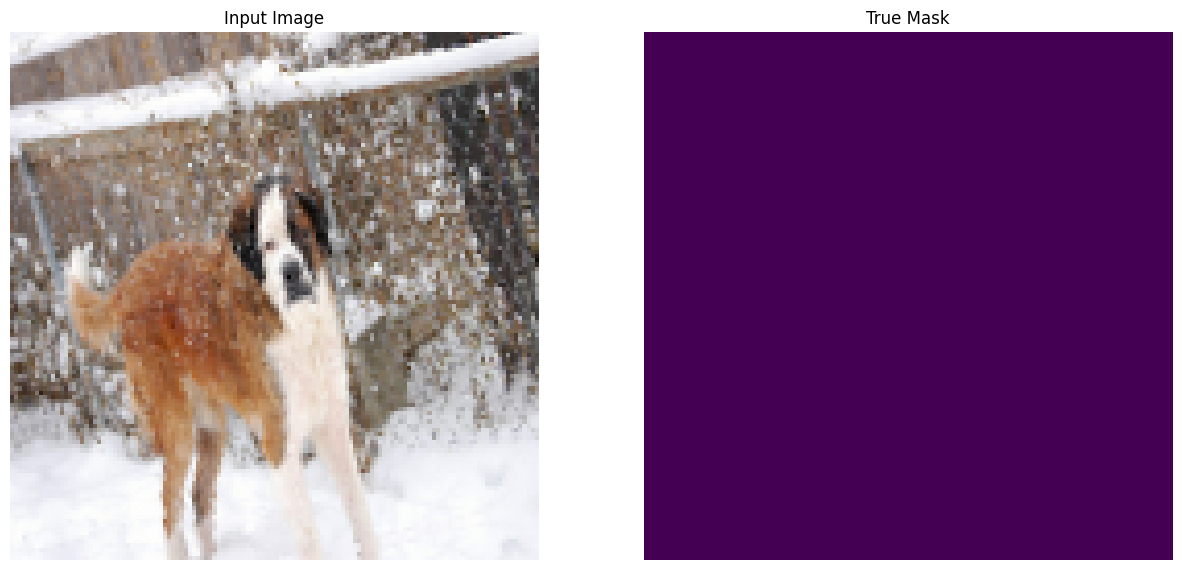

-


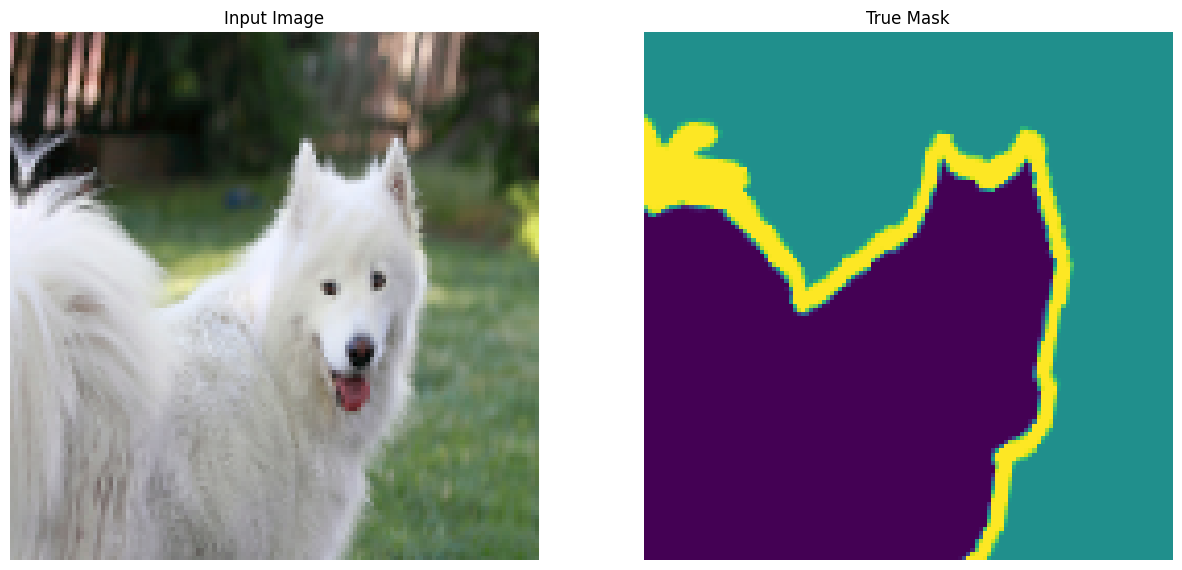

In [10]:
# Funziona che visualizza esempi, maschera reeale e predizione in base a quello che gli viene passato come argomento
def visualizza(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

# visualizzazione di tre esempi
for images, masks in ds_train_batched.take(3):  # recupero tre batch
    sample_image, sample_mask = images[0], masks[0]  # recupero il primo esempio del batch attuale
    print("-")
    visualizza([sample_image, sample_mask])

In [11]:
# recupero del modello standard MobileNetV2 pre-addestrato
# usato poi come encoder nel modello finale
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

9406464/9406464 [==============================] - 0s 0us/step


In [12]:
# recupero dell'output di alcuni layer del modello MobileNetV2

layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  #  8x8
    'block_16_project',      #  4x4
]

base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

base_model_outputs

[<KerasTensor: shape=(None, 64, 64, 96) dtype=float32 (created by layer 'block_1_expand_relu')>,
 <KerasTensor: shape=(None, 32, 32, 144) dtype=float32 (created by layer 'block_3_expand_relu')>,
 <KerasTensor: shape=(None, 16, 16, 192) dtype=float32 (created by layer 'block_6_expand_relu')>,
 <KerasTensor: shape=(None, 8, 8, 576) dtype=float32 (created by layer 'block_13_expand_relu')>,
 <KerasTensor: shape=(None, 4, 4, 320) dtype=float32 (created by layer 'block_16_project')>]

Creiamo l'encoder andando a creare un modello che ha come input gli stessi input del MobileNetV2, mentre ha 5 output, ognuno rappresentante l'output dei blocchi estratti precedentemente

In [15]:
# creazione del blocco encoder
encoder = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
encoder.trainable = False

In [14]:
# creazione del blocco di decoder
# implementato come una serie di layer
# di up-sampling
# ogni "upsample" è un modello sequenziale
# composto da un layer di de-convoluzione
# (Conv2DTranspose) con dropout al 50%
# con funzione di attivazione swish

def upsample(filters, kernel):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2DTranspose(filters, kernel, strides=2, padding='same', use_bias=False))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Activation('swish'))
    return model

decoder = [
    upsample(512, 3),  #  4x4  ->  8x8 | 512 filtri - 3 canali
    upsample(256, 3),  #  8x8  -> 16x16 | 256 filtri - 3 canali
    upsample(128, 3),  # 16x16 -> 32x32 | 128 filtri - 3 canali
    upsample(64, 3),   # 32x32 -> 64x64 | 64 filtri - 3 canali
]

In [17]:
# definizione del modello U-Net utilizzato

def unet_model(output_channels:int):

    # Creo il livello di input allineato con l'input richiesto dal MobileNetV2
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])

    # down-sampling iniziale (encoder)
    # encoder prende l'input allineato con quello richiesto dal MobileNetV2
    #  e mi restituisce 5 output, ognuno rappresentando l'otuput dei livelli estratti
    skips = encoder(inputs)

    for s in skips:
        print(f"Plain -> {s.get_shape()}")

    x = skips[-1]
    skips = reversed(skips[:-1])
    
    for s in skips:
        print(f"Reversed -> {s.get_shape()}")


    # up-sampling (decoder) e associazione delle
    # skip-connections
    for up, skip in zip(decoder, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        # print("Concatenation between {x.name} and {skip.name}")
        x = concat([x, skip])

    # layer finale del modello che restituisce
    # un'immagine di dimensioni uguali all'immagine
    # di input, i cui pixel hanno valore 0, 1 o 2
    # in base alla classe di appartenenza (animale,
    # confine, non animale)
    last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  # 64x64 -> 128x128
    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [18]:
# creazione e compilazione del modello
# animale, confine, non animale
OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)

model.compile(

    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),

    # problema multiclasse -> animale, confine, non animale
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  
                                                                                    
    metrics=['accuracy']
)

Plain -> (None, 64, 64, 96)
Plain -> (None, 32, 32, 144)
Plain -> (None, 16, 16, 192)
Plain -> (None, 8, 8, 576)
Plain -> (None, 4, 4, 320)
Reversed -> (None, 8, 8, 576)
Reversed -> (None, 16, 16, 192)
Reversed -> (None, 32, 32, 144)
Reversed -> (None, 64, 64, 96)


In [19]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 model_1 (Functional)        [(None, 64, 64, 96),      1841984   
                              (None, 32, 32, 144),               
                              (None, 16, 16, 192),               
                              (None, 8, 8, 576),                 
                              (None, 4, 4, 320)]                 
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 8, 8, 3)          8643      
 ranspose)                                                       
                                                                 
Total params: 1,850,627
Trainable params: 8,643
Non-trainable params: 1,841,984
_____________________________________________

In [20]:
def crea_maschera(pred_mask):
    # la label assegnata ad un pixel è quella corrispondente
    # al canale colore con il valore più grande
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]


# definizione di un metodo per visualizzare le predizioni del modello

def visualizza_predizioni(num=1):
    visualizza([sample_image, sample_mask, crea_maschera(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 10s 10s/step


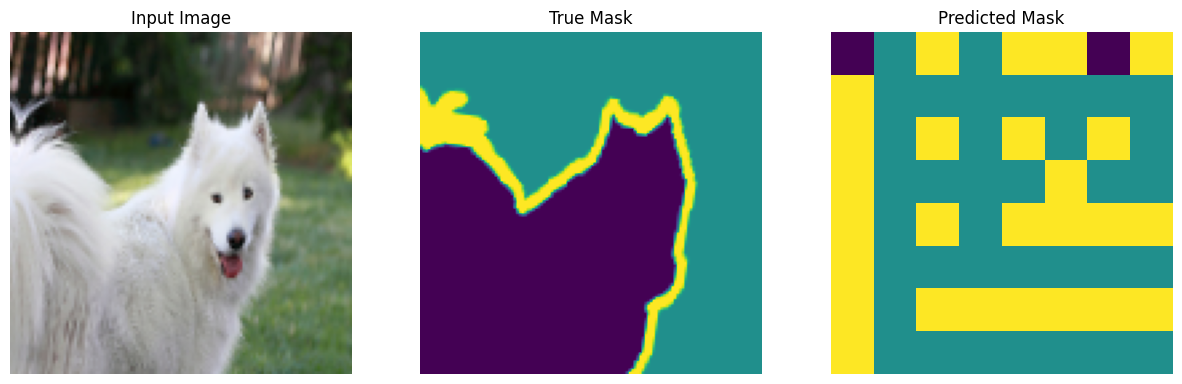

In [21]:
# visualizzazione delle predizioni
# chiamando il modello non ancora addestrato
visualizza_predizioni()

In [22]:
# creazione di un callback per visualizzare come migliora
# il modello durante l'addestramento ogni 10 epoche

class TestCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0 and epoch > 0:
            print ('\n\nPredizione epoca {}\n'.format(epoch + 1))
            visualizza_predizioni()
            print('\n', '-' * 100, '\n')

In [23]:
# configurazione ultimi iper-parametri

STEP_PER_EPOCA = info.splits['train'].num_examples // BATCH_SIZE
EPOCHE = 30
STEP_DI_VALIDAZIONE = info.splits['test'].num_examples // BATCH_SIZE


# addestramento del modello

model_history = model.fit(
    ds_train_batched,
    epochs=EPOCHE,
    steps_per_epoch = STEP_PER_EPOCA,
    validation_steps = STEP_DI_VALIDAZIONE,
    validation_data=ds_test_batched,
    callbacks=[TestCallback()]
)

Epoch 1/30


ValueError: ignored

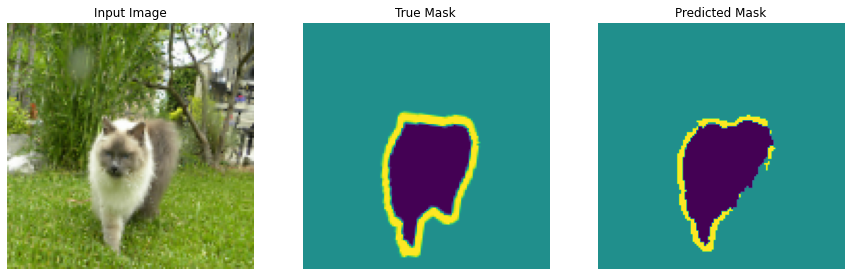

In [ ]:
# visualizzazione predizione dopo l'addestramento

visualizza_predizioni()

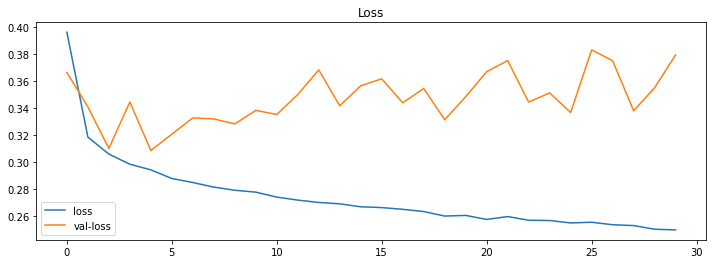

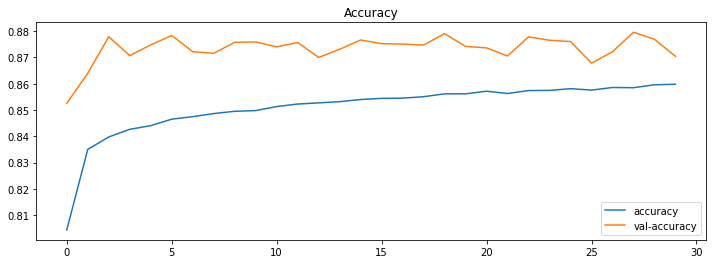

In [ ]:
# visualizzazione andamento addestramento

plt.figure(figsize=(12,4))
plt.title('Loss')
plt.plot(***, label='loss')
plt.plot(***, label='val-loss')
plt.legend()
plt.show()

plt.figure(figsize=(12,4))
plt.title('Accuracy')
plt.plot(***, label='accuracy')
plt.plot(***, label='val-accuracy')
plt.legend()
plt.show()

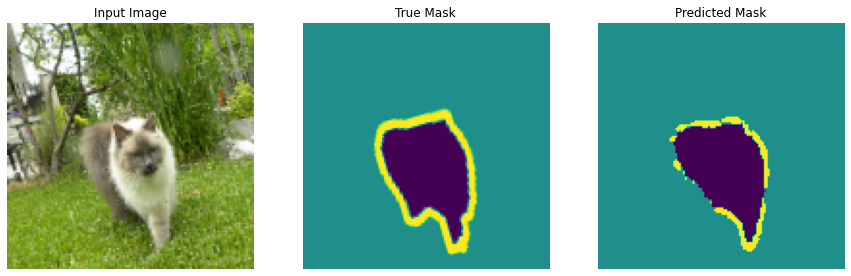

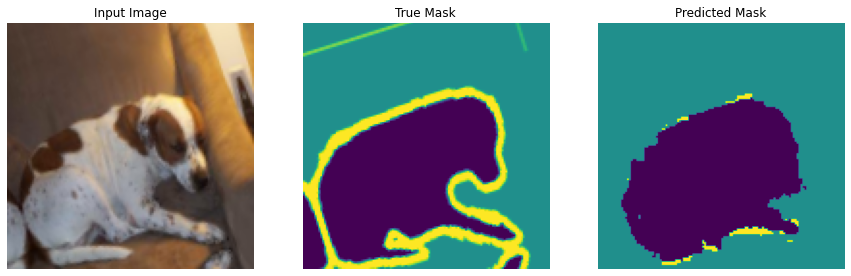

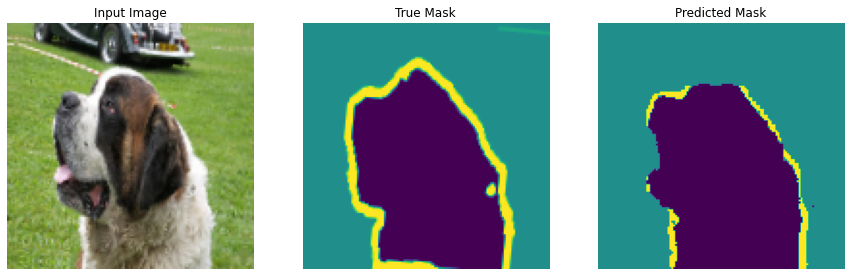

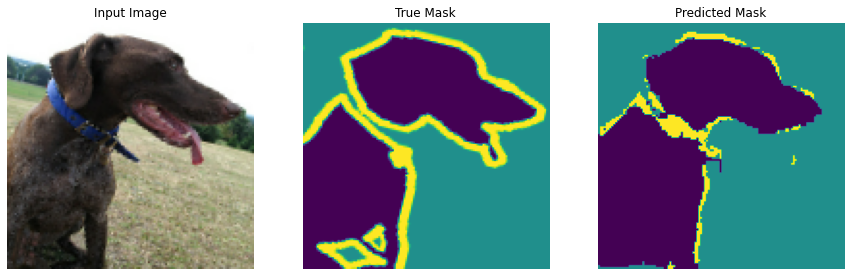

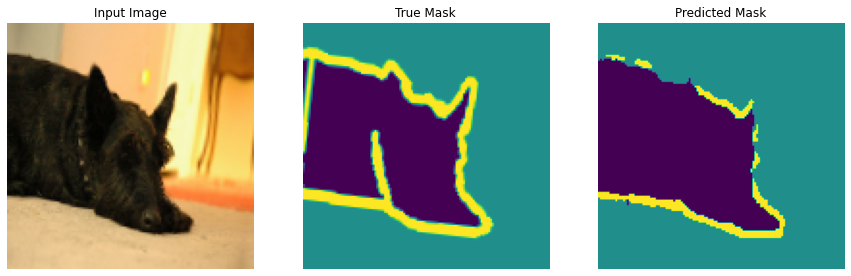

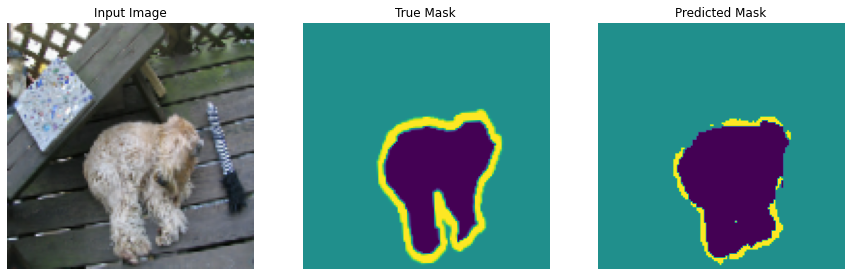

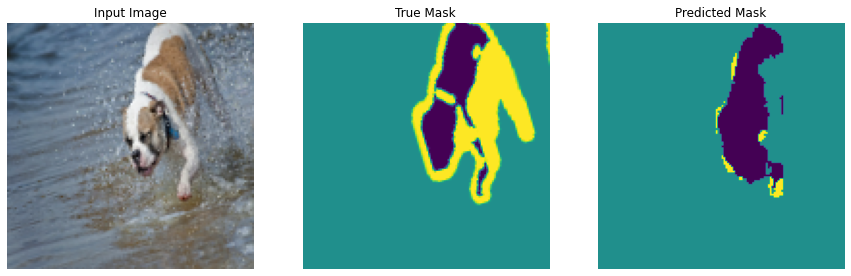

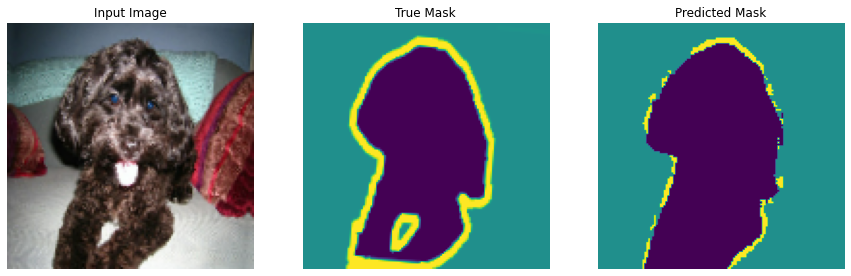

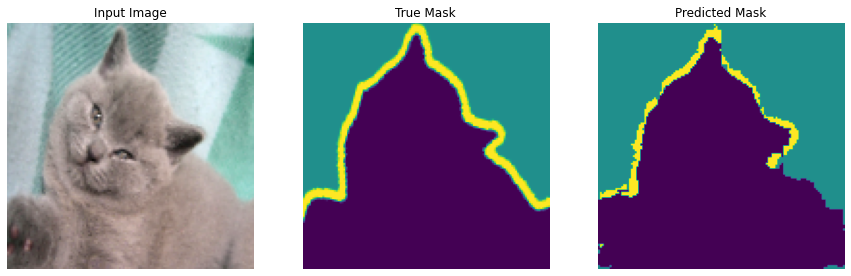

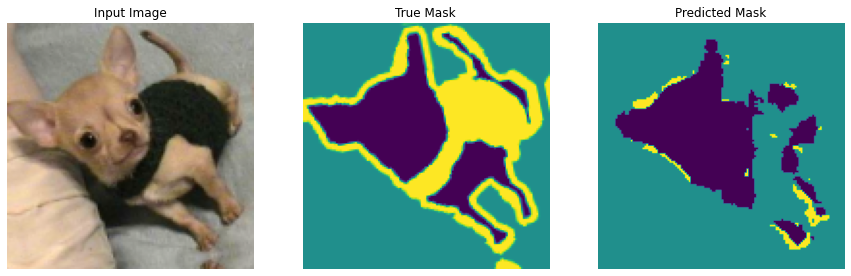

In [ ]:
# previsioni su nuovi esempi dal dataset di test

for images, masks in ds_train_batched.take(10):
    sample_image, sample_mask = images[0], masks[0]
    visualizza_predizioni()

In [ ]:
# test su nuove immagini
# recuperate da internet 
# (non dal dataset originale)

def predizione_nuove_immagini(filename):
    img = cv2.imread(filename)
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.image.resize(img, (128, 128))

    fig = plt.figure(figsize=(15, 15))
    ax1 = fig.add_subplot(121)
    img = img[...,::-1]  # inversione dei canali colore per compatibilità con matplotlib
    ax1.imshow(***)
    img = img[...,::-1]
    ax1.axis('off')
    
    maschera_predetta = model.predict(np.asarray([img]))[0]
    risultato = crea_maschera([maschera_predetta])

    ax2 = fig.add_subplot(122)
    ax2.imshow(***)
    ax2.axis('off')
    
    plt.show()

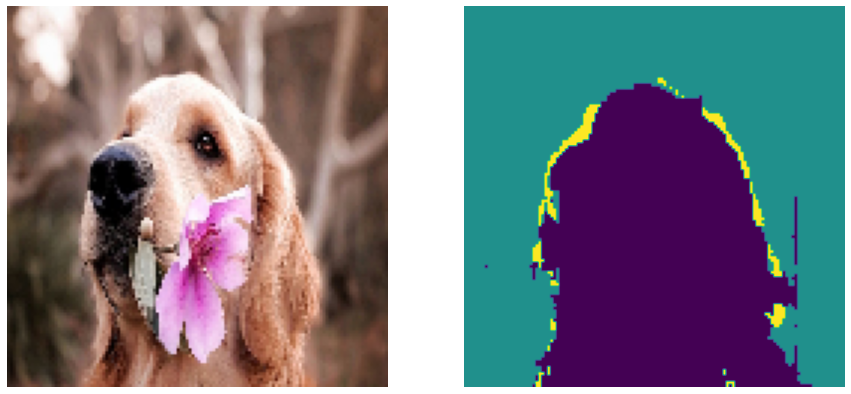

In [ ]:
predizione_nuove_immagini('cane-fiore.jpg')

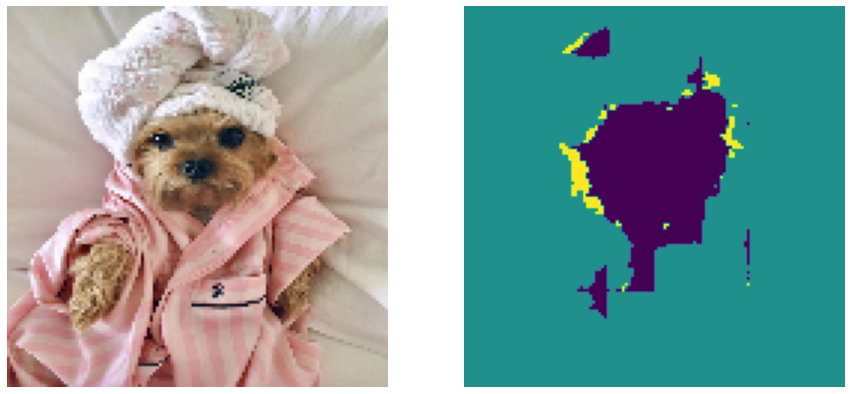

In [ ]:
predizione_nuove_immagini('cane-buffo.jpg')

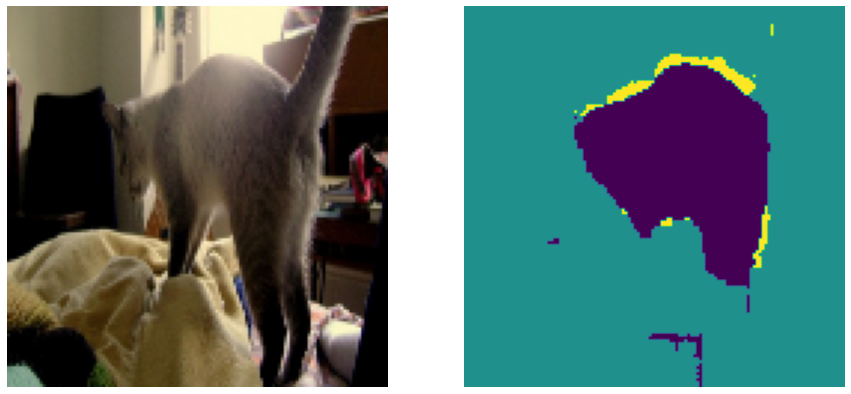

In [ ]:
predizione_nuove_immagini('gatto-casa.png')

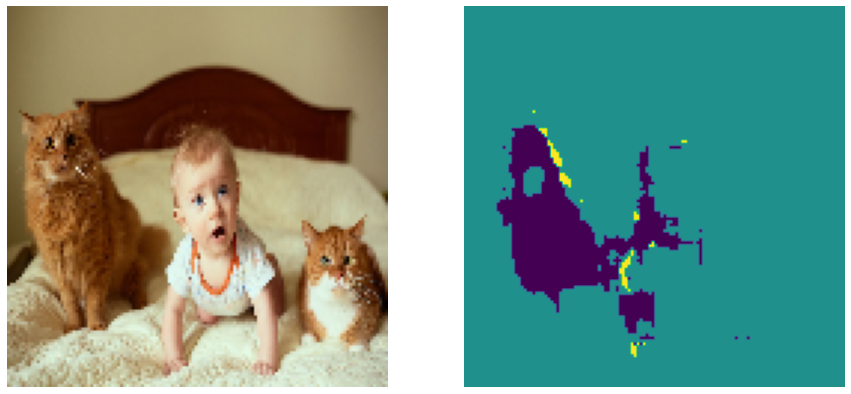

In [ ]:
# test con immagini più complesse e diverse dal dataset
# di addestramento: più soggetti in un'immagine

predizione_nuove_immagini('gatti-bambino.jpg')

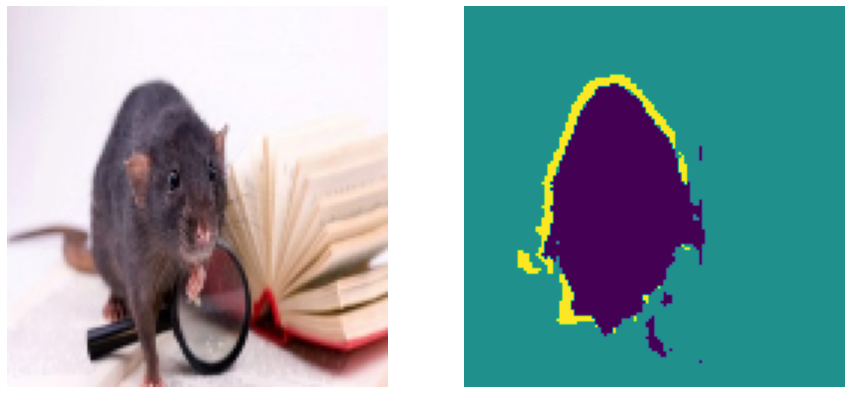

In [ ]:
# test con un soggetto non presente nel dataset
# di addestramento: un topo

predizione_nuove_immagini('topo.jpg')

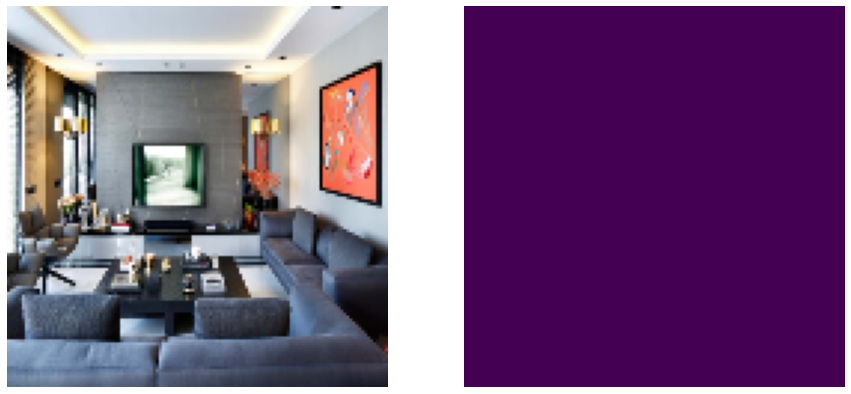

In [ ]:
# test su un'immagine senza alcun animale
# domestico raffigurato

predizione_nuove_immagini('casa.jpg')